# Stress Analysis in Social Media

Leverage the newly published and labelled reddit dataset for stress analysis to develop and improve supervised learning methods for identifying stress, both neural and traditional, and analyze the complexity and diversity of the data and characteristics of each category.

Reference: https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b


In [25]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from datetime import datetime as time

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing
Possible approach of data preprocessing and feature engineeing 
- Tokenization, Removal of punctuations.
- Removal of commonly used words (stopwords).
- Lemmatization or Stemming (Normalization)

In [0]:
nltk.download('stopwords')
nltk.download('wordnet')

path = './data/'
train = pd.read_csv(path + 'dreaddit-train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'dreaddit-test.csv', encoding = "ISO-8859-1")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Tokenization & Remove punctuations

In [0]:
# tokenization: breaks the string into list of words
# tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') # remove number and words that length = 1
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove Stopwords

In [0]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [0]:
train['processed_text'] = train['processed_text'].apply(lambda x: remove_stopwords(x))
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

### Stemming & Lemmatization
Text normalization

In [0]:
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

In [0]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_lemmatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lemmatizer(x))

In [0]:
train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")

## Feature Extraction

### Word2Vec + TD-IDF
TF-IDF Weighted Averaging on Word Embedding

reference: https://gist.github.com/TomLin/30244bcccb7e4f94d191a878a697f698

In [3]:
path = '../../data/preprocessed/'
train = pd.read_pickle(path + "train.pkl")
test = pd.read_pickle(path + "test.pkl")

In [4]:
train.subreddit.unique()

array(['ptsd', 'assistance', 'relationships', 'survivorsofabuse',
       'domesticviolence', 'anxiety', 'homeless', 'stress',
       'almosthomeless', 'food_pantry'], dtype=object)

In [5]:
word2vec = Word2Vec(train['processed_text'],
                size=300,
                window=10,
                min_count=2,
                workers=10,
                iter=100)

### Word2Vec

### plot samples

In [6]:
# find the similar words
semantically_similar_words = {words: [item[0] for item in word2vec.wv.most_similar([words], topn=5)]
                  # for words in ['abuse', 'anxiety', 'financial', 'ptsd', 'social', 'stress', 'love', 'friendship']}
                  for words in ['ptsd', 'social', 'stress', 'love', 'friendship']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

ptsd:['rattl', 'disord', 'multitud', 'borderlin', 'em']
social:['interact', 'medium', 'volunt', 'shi', 'secur']
stress:['everyday', 'surround', 'knot', 'nausea', 'throw']
love:['passion', 'sweet', 'platon', 'beauti', 'fun']
friendship:['jessi', 'beyond', 'lisa', 'avenu', 'handl']


In [7]:
# find the similarity of two words
print(word2vec.wv.similarity(w1='love', w2='stress'))

0.12564425


In [8]:
keys = ['ptsd', 'social', 'stress', 'love', 'friendship']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec.wv.most_similar(word, topn=20):
        words.append(similar_word)
        embeddings.append(word2vec[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [9]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

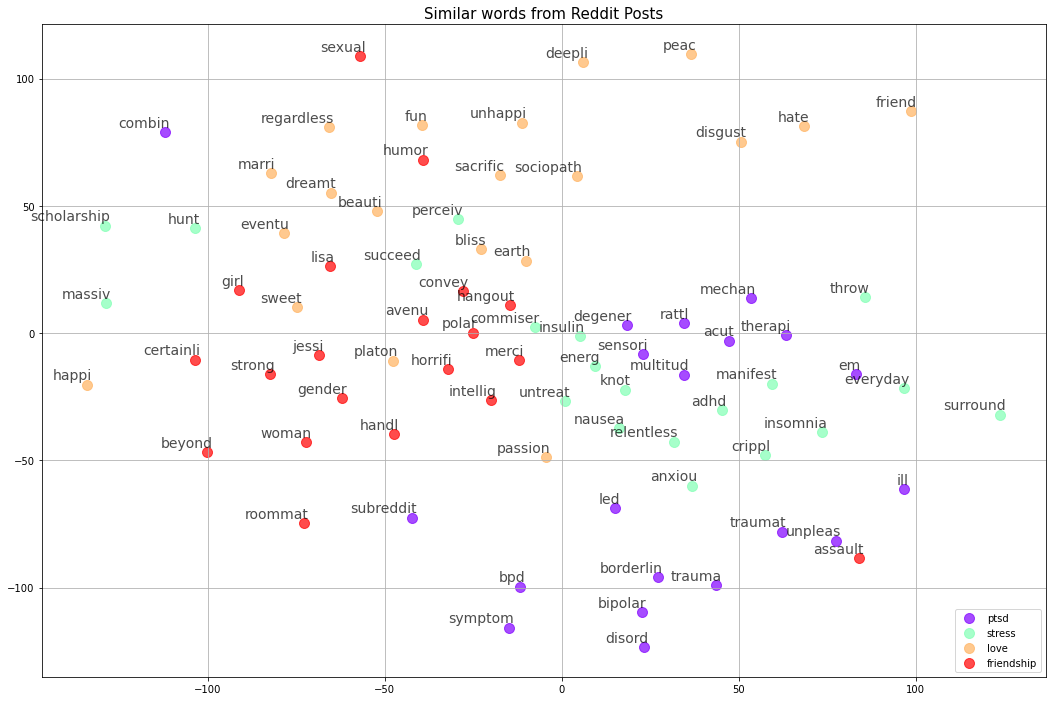

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename='similar_words'):
    plt.figure(figsize=(18, 12))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        # outliers
        if 'worker' in words or 'co' in words:
                continue
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, s=100, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom', size=14)
    plt.legend(loc=4) # , prop={'size': 20}
    plt.title(title, size=15)
    plt.grid(True)
    if filename:
        plt.savefig('../../figs/' + filename+'.png')
    plt.show()

tsne_plot_similar_words('Similar words from Reddit Posts', keys, embeddings_en_2d, word_clusters, 0.7)

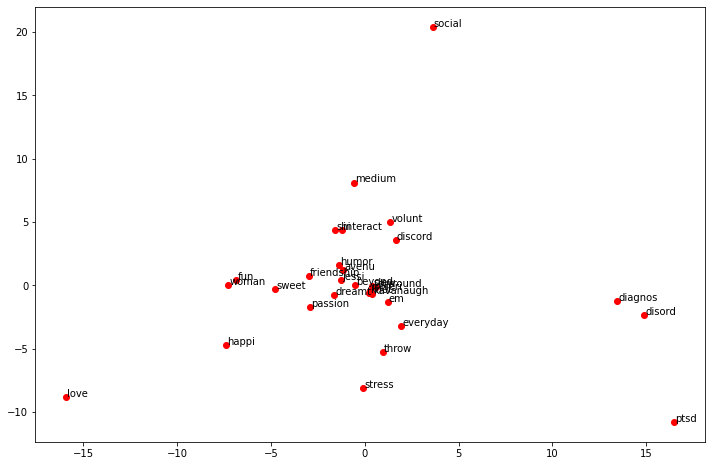

In [0]:
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

word_vectors = word2vec.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(12, 8))
# name = ['abuse', 'anxiety', 'financial', 'ptsd', 'social', 'stress', 'love']
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

### generate embeddings

In [6]:
class TfidfEmbeddingVectorizer(object):

    def __init__(self, word_model):

        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size

    def fit(self, docs):  # comply with scikit-learn transformer requirement
        """
        Fit in a list of docs, which had been preprocessed and tokenized,
        such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
        Then build up a tfidf model to compute each word's idf as its weight.
        Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
        :param: pre_processed_docs: list of docs, which are tokenized
        :return: self
        """

        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer() # default 1-gram 
        tfidf.fit(text_docs)  # must be list of text string

        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        self.word_idf_weight = defaultdict(lambda: max_idf,
                                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self


    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector


    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """

        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [7]:
train = train[train['confidence']>0.8]
test = test[test['confidence']>0.8]

In [8]:
train_token = train['processed_text']
test_token = test['processed_text']

X = train_token.append(test_token)
X = X.reset_index(drop=True)

In [9]:
tfidf_vec_tr = TfidfEmbeddingVectorizer(word2vec)

tfidf_vec_tr.fit(X)  # fit tfidf model first

In [11]:
tfidf_doc_vec = tfidf_vec_tr.transform(X)

### Doc2Vec

In [67]:
doc_words = train['processed_text'].append(test['processed_text'])
doc_words = doc_words.reset_index(drop = True)

doc_ids = doc_words.index
tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(doc_words, doc_ids)]

In [68]:
class DocModel(object):

	def __init__(self, docs, **kwargs):
		"""
		:param docs: list of TaggedDocument
		:param kwargs: dictionary of (key,value) for Doc2Vec arguments
		"""
		self.model = Doc2Vec(**kwargs)
		self.docs = docs
		self.model.build_vocab([x for x in self.docs])

	def custom_train(self, fixed_lr=False, fixed_lr_epochs=None):
		"""
		Train Doc2Vec with two options, without fixed learning rate(recommended) or with fixed learning rate.
		Fixed learning rate also includes implementation of shuffling training dataset.
		:param fixed_lr: boolean
		:param fixed_lr_epochs: num of epochs for fixed lr training
		"""
		if not fixed_lr:
			self.model.train([x for x in self.docs],
					 total_examples=len(self.docs),
					 epochs=self.model.epochs)
		else: # change the learning rate during the training
			for _ in range(fixed_lr_epochs):
				self.model.train(utils.shuffle([x for x in self.docs]),
						 total_examples=len(self.docs),
						 epochs=1)
				self.model.alpha -= 0.002
				self.model.min_alpha = self.model.alpha  # fixed learning rate


	def test_orig_doc_infer(self):
		"""
		Use the original doc as input for model's vector inference,
		and then compare using most_similar()
		to see if model finds the original doc id be the most similar doc to the input.
		"""
		idx = np.random.randint(len(self.docs))
		print('idx: ' + str(idx))
		doc = [doc for doc in self.docs if doc.tags[0] == idx]
		inferred_vec = self.model.infer_vector(doc[0].words)
		print(self.model.docvecs.most_similar([inferred_vec]))  # wrap vec in a list

In [69]:
# Configure keyed arguments for Doc2Vec model.
dm_args = {
    'dm': 1,
    'dm_mean': 1,
    'vector_size': 300,
    'window': 5,
    'negative': 5,
    'hs': 0,
    'min_count': 2,
    'sample': 0,
    # 'workers': workers,
    'alpha': 0.025,
    'min_alpha': 0.025,
    'epochs': 100,
    'comment': 'alpha=0.025'
}
# Instantiate a pv-dm model.
dm = DocModel(docs=tagdocs, **dm_args)
dm.custom_train()

In [70]:
dm_doc_vec_ls = []
for i in range(len(dm.model.docvecs)):
    dm_doc_vec_ls.append(dm.model.docvecs[i])

dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
dm_doc_vec.shape


(1555, 300)

## Classification

### Word Embedding + TF-IDF

In [12]:
scaler = StandardScaler()
tfidf_doc_vec_scaled = scaler.fit_transform(tfidf_doc_vec)

In [15]:
# X_train = tfidf_doc_vec[:len(train_conf)]
# y_train = train_conf['label']

# X_test = tfidf_doc_vec[len(train_conf):]
# y_test = test_conf['label']

X_train = tfidf_doc_vec[:len(train)]
y_train = train['label']

X_test = tfidf_doc_vec[len(train):]
y_test = test['label']
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [16]:
clf_dict = {'log reg': LogisticRegression(random_state=42), 
            'naive bayes': GaussianNB(), 
            'linear svc': LinearSVC(random_state=42),
            'sgd classifier': SGDClassifier(random_state=42),
            'ada boost': AdaBoostClassifier(n_estimators=100, random_state=42),
            'gradient boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'CART': DecisionTreeClassifier(random_state=42),
            'random forest': RandomForestClassifier(n_estimators=100, random_state=42)}

In [22]:
train_times = []
test_times = []

In [28]:
for name, clf in clf_dict.items():
    train_time = time.now()
    model = clf.fit(X_train, y_train)
    train_times.append(time.now()-train_time)
    test_time = time.now()
    y_pred = model.predict(X_test)
    test_times.append(time.now()-test_time)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))


Accuracy of log reg: 0.8389261744966443
Accuracy of naive bayes: 0.785234899328859
Accuracy of linear svc: 0.8288590604026845
Accuracy of sgd classifier: 0.8120805369127517
Accuracy of ada boost: 0.825503355704698
Accuracy of gradient boosting: 0.8154362416107382
Accuracy of CART: 0.7281879194630873
Accuracy of random forest: 0.825503355704698


#### XGBoost

In [29]:
# on CPU:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
params = {"objective":'multi:softprob','colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10 , 'num_class': 2, 'random_state': 42}
steps = 20  # The number of training iterations
train_time = time.now()         
model = xgb.train(params, D_train, steps)
train_times.append(time.now()-train_time)
test_time = time.now()
preds = model.predict(D_test)
test_times.append(time.now()-test_time)
y_pred = np.asarray([np.argmax(line) for line in preds])

In [46]:
time_df = pd.DataFrame()

In [48]:
time_df['test_times'] = test_times
time_df['train_times'] = train_times

In [49]:
time_df.mean()

test_times    00:00:00.004543
train_times   00:00:01.837573
dtype: timedelta64[ns]

In [37]:
print('Accuracy', accuracy_score(y_pred, y_test))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Accuracy 0.8221476510067114
Precision 0.7897435897435897
Recall 0.927710843373494
F1-Score 0.853185595567867


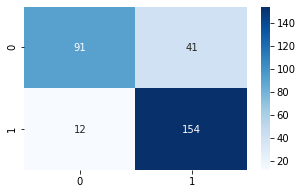

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

#### Random Forest

In [41]:
clf =RandomForestClassifier(n_estimators=100, random_state=42)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy'.format(name), accuracy_score(y_pred, y_test))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Accuracy 0.8288590604026845
Precision 0.7948717948717948
Recall 0.9337349397590361
F1-Score 0.8587257617728531


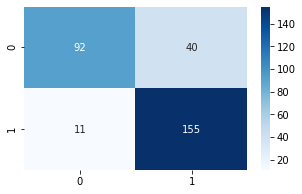

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

### Doc2Vec

In [73]:
dm_doc_vec_scaled = scaler.fit_transform(dm_doc_vec)
dm_doc_vec_scaled

array([[-1.24286183, -2.32772137, -0.20884831, ...,  0.51363544,
         0.21448127,  0.80804342],
       [-0.12173724, -0.10431684, -0.81892547, ...,  0.14444213,
        -0.84212287, -0.17600454],
       [ 0.85968595,  1.58961531, -2.91789551, ..., -0.58271818,
        -1.33916057, -0.30525381],
       ...,
       [-0.94097913, -0.77661128,  0.74033016, ...,  0.66474872,
        -0.82752146,  1.11207701],
       [ 0.98139474, -0.83308522,  1.29516579, ..., -0.8744808 ,
        -0.52186766,  0.93647811],
       [ 1.05401526,  1.80379236, -0.40415016, ..., -0.81409322,
        -0.43171089,  0.22329592]])

In [74]:
X_train_doc = dm_doc_vec_scaled[:len(train)]
y_train_doc = train['label']

X_test_doc = dm_doc_vec_scaled[len(train):] #dm_doc_vec_scaled
y_test_doc = test['label']

# X = dm_doc_vec_scaled
# y = train['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [75]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train_doc, y_train_doc)
    y_pred_doc = model.predict(X_test_doc)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred_doc, y_test_doc))

Accuracy of log reg: 0.8523489932885906
Accuracy of naive bayes: 0.7818791946308725
Accuracy of linear svc: 0.8288590604026845
Accuracy of sgd classifier: 0.8053691275167785
Accuracy of ada boost: 0.7751677852348994
Accuracy of gradient boosting: 0.802013422818792
Accuracy of CART: 0.7348993288590604
Accuracy of random forest: 0.8154362416107382


#### XGBoost

In [76]:
D_train_doc = xgb.DMatrix(X_train_doc, label=y_train_doc)
D_test_doc = xgb.DMatrix(X_test_doc, label=y_test_doc)
params = {"objective":'multi:softprob','max_depth': 3, 'alpha': 10 , 'num_class': 2, 'random_state': 0}
steps = 20  # The number of training iterations
model = xgb.train(params, D_train_doc, steps)
preds = model.predict(D_test_doc)
y_pred_doc = np.asarray([np.argmax(line) for line in preds])

In [77]:
name = 'XGBoost'
print('Accuracy of {}:'.format(name), accuracy_score(y_pred_doc, y_test_doc))
print('Precision', precision_score(y_test_doc, y_pred_doc))
print('Recall', recall_score(y_test_doc, y_pred_doc))
print('F1-Score', f1_score(y_test_doc, y_pred_doc))

Accuracy of XGBoost: 0.785234899328859
Precision 0.7712765957446809
Recall 0.8734939759036144
F1-Score 0.8192090395480226


#### Logistic Regression

In [78]:
clf = LogisticRegression(random_state=0).fit(X_train_doc, y_train_doc)
y_pred_doc = clf.predict(X_test_doc)

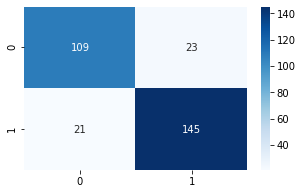

In [79]:
# Confusion Matrix
cm = confusion_matrix(y_test_doc, y_pred_doc)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [80]:
print('Accuracy', accuracy_score(y_pred_doc, y_test_doc))
print('Precision', precision_score(y_test_doc, y_pred_doc))
print('Recall', recall_score(y_test_doc, y_pred_doc))
print('F1-Score', f1_score(y_test_doc, y_pred_doc))

Accuracy 0.8523489932885906
Precision 0.8630952380952381
Recall 0.8734939759036144
F1-Score 0.8682634730538922


### Doc2Vec + Word2Vec

In [81]:
dm_doc_vec_scaled = scaler.fit_transform(dm_doc_vec)
fts = []
for i in range(len(tfidf_doc_vec)):
  # combine doc2vec and word2vec features
    ft = list(tfidf_doc_vec_scaled[i]) + list(dm_doc_vec_scaled[i])
    fts.append(ft)
# (3553, 600)
fts = np.array(fts)

In [82]:
X = fts #scaler.fit_transform(fts)

X_train_combine = X[:len(train)]
y_train_combine = train['label']

X_test_combine = X[len(train):]
y_test_combine = test['label']

In [83]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train_combine, y_train_combine)
    y_pred_combine = model.predict(X_test_combine)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred_combine, y_test_combine))

Accuracy of log reg: 0.8187919463087249
Accuracy of naive bayes: 0.7885906040268457
Accuracy of linear svc: 0.8087248322147651
Accuracy of sgd classifier: 0.7986577181208053
Accuracy of ada boost: 0.8154362416107382
Accuracy of gradient boosting: 0.8053691275167785
Accuracy of CART: 0.7416107382550335
Accuracy of random forest: 0.825503355704698


#### Random Forest

In [84]:
clf = RandomForestClassifier(random_state=42).fit(X_train_combine, y_train_combine)
y_pred_combine = clf.predict(X_test_combine)

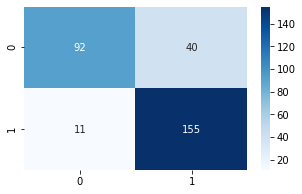

In [85]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [86]:
print('Accuracy', accuracy_score(y_test_combine, y_pred_combine))
print('Precision', precision_score(y_test_combine, y_pred_combine))
print('Recall', recall_score(y_test_combine, y_pred_combine))
print('F1-Score', f1_score(y_test_combine, y_pred_combine))

Accuracy 0.825503355704698
Precision 0.7908163265306123
Recall 0.9337349397590361
F1-Score 0.8563535911602209


### XGBoost

In [87]:
D_train_combine = xgb.DMatrix(X_train_combine, label=y_train_combine)
D_test_combine = xgb.DMatrix(X_test_combine, label=y_test_combine)
params = {"objective":'multi:softprob','max_depth': 3, 'alpha': 10 , 'num_class': 2, 'random_state': 0}
steps = 20  # The number of training iterations
model = xgb.train(params, D_train_combine, steps)
preds = model.predict(D_test_combine)
y_pred_combine = np.asarray([np.argmax(line) for line in preds])